In [46]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel, UNet2DConditionModel
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np

import data.dataset as ds
import data.CI as CI
import model_ae_FD as vae


device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_name = 'UNet2DConditionLatent'

# load encoder
encoder = 'models/ae_mlp.pt'
encoder = torch.load(encoder)

x = np.random.random_sample((16, 1, 64, 64))
x = torch.tensor(x).float().to(device)

a,b,c = encoder.encoder_to_img(x)

Using device: cuda


In [31]:
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.01
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

train_transforms = v2.Compose([
    v2.ToTensor(),
    # gauss_noise_tensor,
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(90, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.GaussianBlur(3, sigma=(0.1, 0.5)),
    v2.CenterCrop(64),
])

val_transforms = v2.Compose([
    v2.ToTensor(),
    v2.CenterCrop(64),
])

Img Shape: torch.Size([1, 64, 64])
CI Shape: torch.Size([120])
Class Shape: torch.Size([7])

18396
Input shape: torch.Size([8, 1, 64, 64])
Labels: tensor([6, 2, 0, 4, 4, 1, 4, 0])


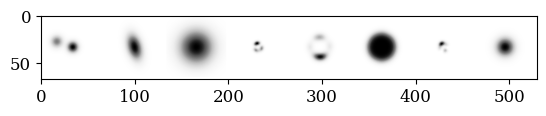

In [32]:
# Load the dataset
batch_size = 8


data_dir = 'data/datasets/v2/'
mnames = ['gauss', 'disk', 'ellipse', 'ring', 'mring', 'disk2', 'gauss2']

filenames = np.array([data_dir + 'imgs_' + m + '.npy' for m in mnames])
dataset = ds.ImgDataset(filenames, transform=train_transforms)

print('Img Shape:', dataset[0][0].shape)
print('CI Shape:', dataset[0][1].shape)
print('Class Shape:', dataset[0][2].shape)

print()
print(len(dataset))

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# View some examples
x, ci, y = next(iter(train_dataloader))
y = torch.argmax(y, dim=1)
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [33]:
class UNet2DCondition(nn.Module):
    def __init__(self, ci_dim=120, time_cond_proj_dim=512):
        super().__init__()

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DConditionModel(
            sample_size=16,  # the target image resolution
            in_channels=4, # Additional input channels for class cond.
            out_channels=4,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
            # cross_attention_dim = 1,
            encoder_hid_dim=ci_dim,
            time_cond_proj_dim=time_cond_proj_dim,
        )

        

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, ci, guidance_scale=None):
        # Shape of x:
        bs, ch, w, h = x.shape

        if guidance_scale is not None:
            guidance_scale_tensor = torch.tensor(guidance_scale - 1).repeat(bs)
            timestep_cond = self.get_guidance_scale_embedding(guidance_scale_tensor, embedding_dim=self.model.config.time_cond_proj_dim).to(device=device, dtype=x.dtype)
        else:
            timestep_cond = None

        return self.model(x,t,ci, timestep_cond=timestep_cond).sample

    def get_guidance_scale_embedding(self, w: torch.Tensor, embedding_dim: int = 512, dtype: torch.dtype = torch.float32) -> torch.Tensor:
        """
        See https://github.com/google-research/vdm/blob/dc27b98a554f65cdc654b800da5aa1846545d41b/model_vdm.py#L298

        Args:
            w (`torch.Tensor`):
                Generate embedding vectors with a specified guidance scale to subsequently enrich timestep embeddings.
            embedding_dim (`int`, *optional*, defaults to 512):
                Dimension of the embeddings to generate.
            dtype (`torch.dtype`, *optional*, defaults to `torch.float32`):
                Data type of the generated embeddings.

        Returns:
            `torch.Tensor`: Embedding vectors with shape `(len(w), embedding_dim)`.
        """
        assert len(w.shape) == 1
        w = w * 1000.0

        half_dim = embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
        emb = w.to(dtype)[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if embedding_dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0, 1))
        assert emb.shape == (w.shape[0], embedding_dim)
        return emb

In [34]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
# Our network
net = UNet2DCondition().to(device)

# Keeping a record of the losses for later viewing
losses = []

In [39]:
# Training loop :

# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 50

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)


# The training loop
for epoch in range(n_epochs):
    for x, ci, y in tqdm(train_dataloader):
        y = torch.argmax(y, dim=1)
        # Get some data and prepare the corrupted version
        x, _, _ = encoder.encoder_to_img(x.to(device))
        x = x #* 2 - 1
        y = y.to(device)

        ci = ci.reshape(-1, 1, ci.shape[-1]).to(device)
        

        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, ci)  


        # Calculate the loss
        loss = loss_fn(pred, noise)  # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch+1}. Average of the last 100 loss values: {avg_loss:05f}")


100%|██████████| 144/144 [01:43<00:00,  1.39it/s]


Finished epoch 1. Average of the last 100 loss values: 0.002256


100%|██████████| 144/144 [01:44<00:00,  1.37it/s]


Finished epoch 2. Average of the last 100 loss values: 0.002049


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


Finished epoch 3. Average of the last 100 loss values: 0.002037


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


Finished epoch 4. Average of the last 100 loss values: 0.001967


100%|██████████| 144/144 [01:44<00:00,  1.38it/s]


Finished epoch 5. Average of the last 100 loss values: 0.002002


100%|██████████| 144/144 [01:43<00:00,  1.38it/s]


Finished epoch 6. Average of the last 100 loss values: 0.001957


100%|██████████| 144/144 [01:43<00:00,  1.39it/s]


Finished epoch 7. Average of the last 100 loss values: 0.001818


100%|██████████| 144/144 [01:44<00:00,  1.38it/s]


Finished epoch 8. Average of the last 100 loss values: 0.001887


100%|██████████| 144/144 [01:44<00:00,  1.38it/s]


Finished epoch 9. Average of the last 100 loss values: 0.001847


100%|██████████| 144/144 [01:43<00:00,  1.39it/s]


Finished epoch 10. Average of the last 100 loss values: 0.001770


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


Finished epoch 11. Average of the last 100 loss values: 0.001674


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


Finished epoch 12. Average of the last 100 loss values: 0.001724


100%|██████████| 144/144 [01:46<00:00,  1.35it/s]


Finished epoch 13. Average of the last 100 loss values: 0.001672


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 14. Average of the last 100 loss values: 0.001603


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 15. Average of the last 100 loss values: 0.001662


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 16. Average of the last 100 loss values: 0.001589


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 17. Average of the last 100 loss values: 0.001634


100%|██████████| 144/144 [01:48<00:00,  1.32it/s]


Finished epoch 18. Average of the last 100 loss values: 0.001646


100%|██████████| 144/144 [01:47<00:00,  1.34it/s]


Finished epoch 19. Average of the last 100 loss values: 0.001579


100%|██████████| 144/144 [01:47<00:00,  1.34it/s]


Finished epoch 20. Average of the last 100 loss values: 0.001461


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 21. Average of the last 100 loss values: 0.001507


100%|██████████| 144/144 [01:49<00:00,  1.32it/s]


Finished epoch 22. Average of the last 100 loss values: 0.001571


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 23. Average of the last 100 loss values: 0.001507


100%|██████████| 144/144 [01:47<00:00,  1.34it/s]


Finished epoch 24. Average of the last 100 loss values: 0.001490


100%|██████████| 144/144 [01:47<00:00,  1.33it/s]


Finished epoch 25. Average of the last 100 loss values: 0.001424


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 26. Average of the last 100 loss values: 0.001522


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 27. Average of the last 100 loss values: 0.001430


100%|██████████| 144/144 [01:47<00:00,  1.34it/s]


Finished epoch 28. Average of the last 100 loss values: 0.001333


100%|██████████| 144/144 [01:48<00:00,  1.32it/s]


Finished epoch 29. Average of the last 100 loss values: 0.001438


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 30. Average of the last 100 loss values: 0.001417


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 31. Average of the last 100 loss values: 0.001345


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 32. Average of the last 100 loss values: 0.001408


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 33. Average of the last 100 loss values: 0.001393


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 34. Average of the last 100 loss values: 0.001277


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 35. Average of the last 100 loss values: 0.001280


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 36. Average of the last 100 loss values: 0.001315


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


Finished epoch 37. Average of the last 100 loss values: 0.001348


100%|██████████| 144/144 [01:49<00:00,  1.32it/s]


Finished epoch 38. Average of the last 100 loss values: 0.001258


100%|██████████| 144/144 [01:49<00:00,  1.32it/s]


Finished epoch 39. Average of the last 100 loss values: 0.001301


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


Finished epoch 40. Average of the last 100 loss values: 0.001272


100%|██████████| 144/144 [01:45<00:00,  1.36it/s]


Finished epoch 41. Average of the last 100 loss values: 0.001255


100%|██████████| 144/144 [01:44<00:00,  1.37it/s]


Finished epoch 42. Average of the last 100 loss values: 0.001264


100%|██████████| 144/144 [01:44<00:00,  1.37it/s]


Finished epoch 43. Average of the last 100 loss values: 0.001256


100%|██████████| 144/144 [01:45<00:00,  1.36it/s]


Finished epoch 44. Average of the last 100 loss values: 0.001222


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


Finished epoch 45. Average of the last 100 loss values: 0.001264


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


Finished epoch 46. Average of the last 100 loss values: 0.001254


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


Finished epoch 47. Average of the last 100 loss values: 0.001316


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


Finished epoch 48. Average of the last 100 loss values: 0.001172


100%|██████████| 144/144 [01:45<00:00,  1.36it/s]


Finished epoch 49. Average of the last 100 loss values: 0.001183


100%|██████████| 144/144 [01:44<00:00,  1.37it/s]

Finished epoch 50. Average of the last 100 loss values: 0.001131


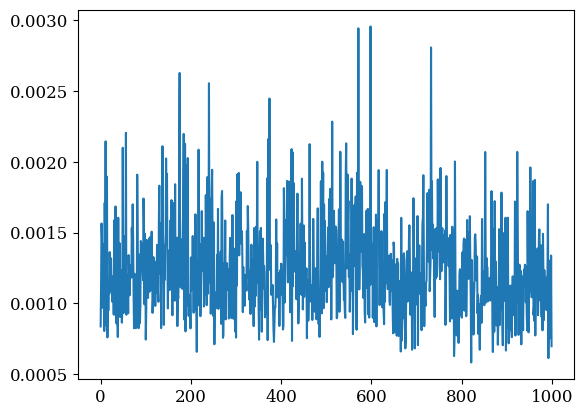

In [41]:
# View the loss curve
plt.plot(losses[-1000:])

# np.save('models/history/'+model_name+'.npy', losses)

In [43]:
# save model
# torch.save(net.state_dict(), 'models/'+model_name+'.pt')

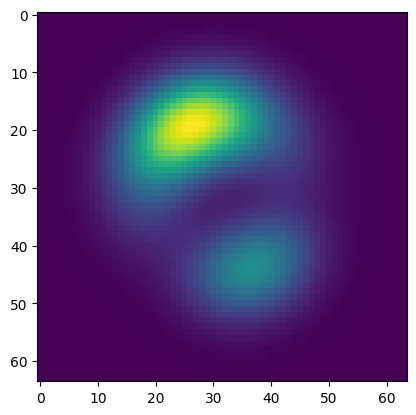

In [13]:
for x, ci, y in train_dataloader:
    y = torch.argmax(y, dim=1)
    im = x[0].reshape(1, 1, 64, 64).cpu()

    fig, ax = plt.subplots()
    ax.imshow(im.reshape(64, 64))
    break

Loading fits image:  /home/lai075/GitHub/CI_ImRec/Images/ellipse.fits


1000it [00:17, 55.77it/s]


tensor(20.9254, device='cuda:0')
tensor(21.7382, device='cuda:0')


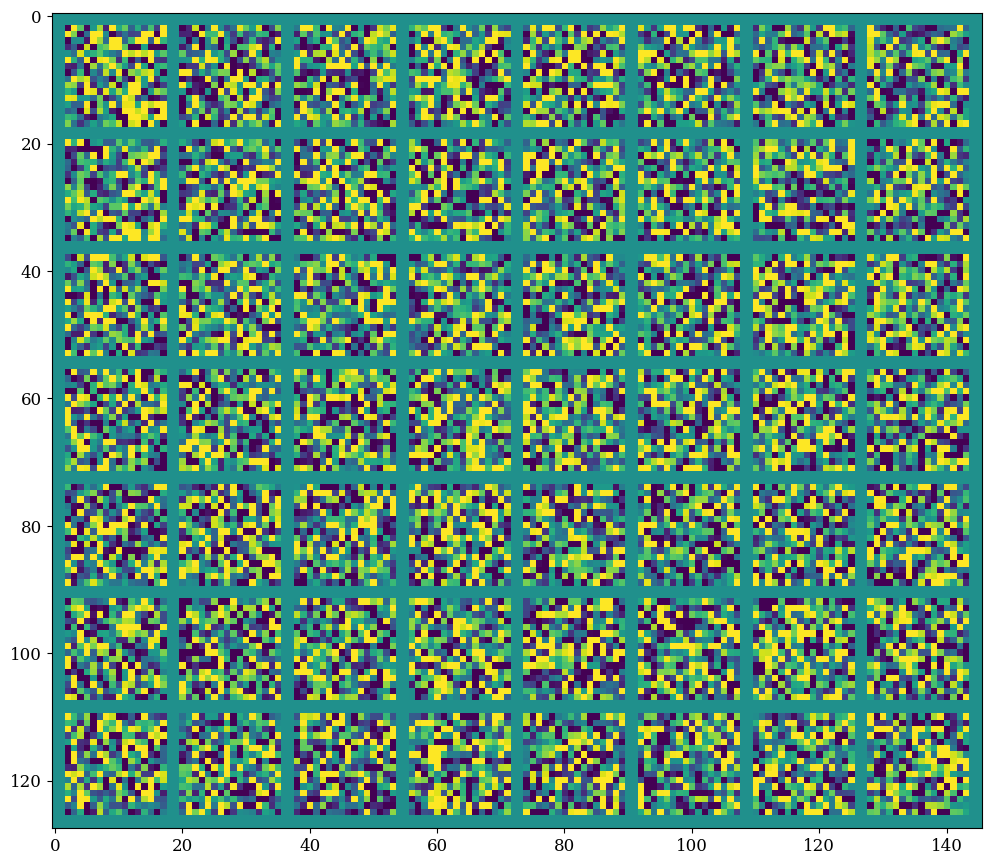

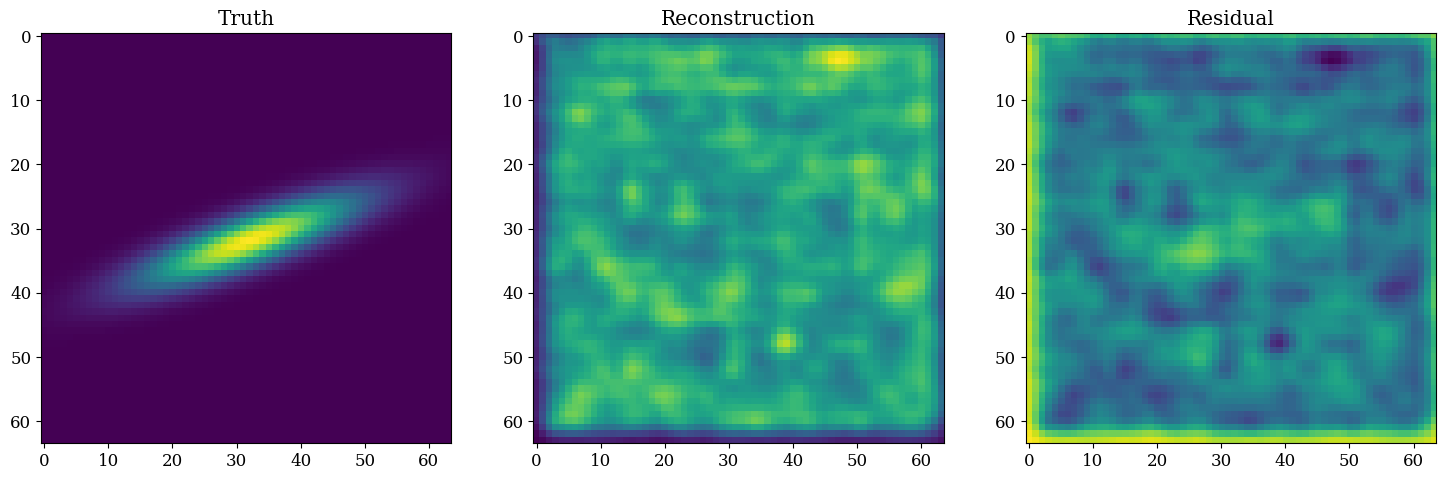

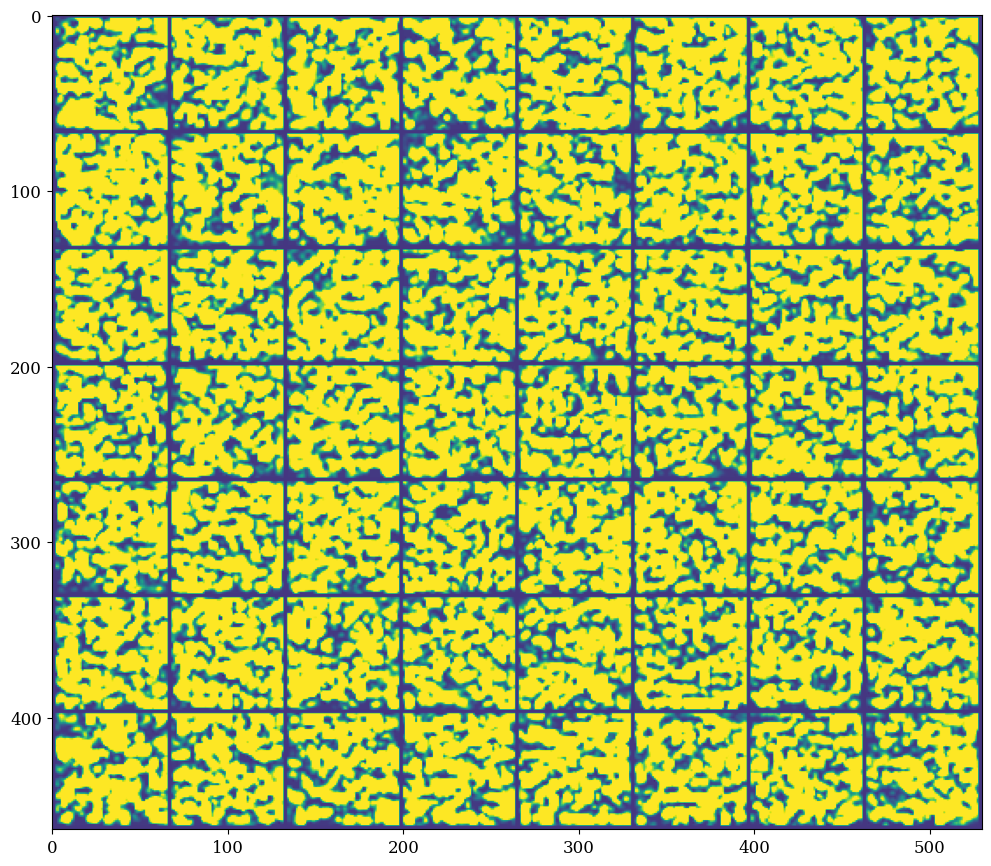

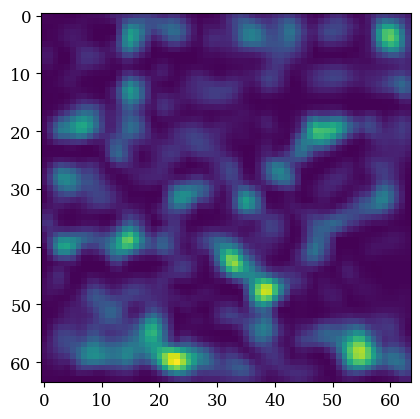

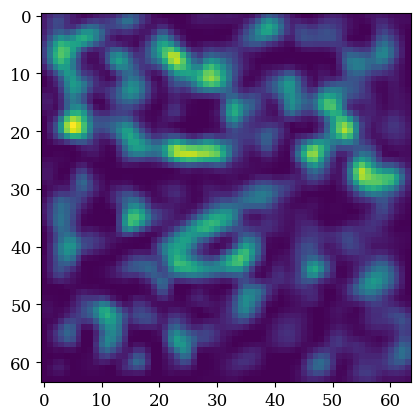

In [44]:
# test with custom image

import ehtim as eh

imgdim = 64

load_fits = '/home/lai075/GitHub/CI_ImRec/Images/ellipse.fits'

img = eh.image.load_fits(load_fits)

name = load_fits.split('/')[-1].split('.')[0]

im = img.regrid_image(img.fovx(), imgdim)
im = im.imarr()

im = im/np.max(im) # normalise the intensity
im = val_transforms(im)

Closure = CI.Closure_Invariants('data/ehtuv.npz')
invs = Closure.FTCI(np.array([im])).reshape(-1)

invs = torch.Tensor(invs).reshape(1, -1)
invs = invs.to(device)

im = np.array(im.reshape(imgdim, imgdim))

# load model from .pt
net = UNet2DCondition().to(device)
net.load_state_dict(torch.load('models/'+model_name+'.pt'))

# Sampling some different digits:
n_classes = len(mnames)
n_images = batch_size
# Prepare random x to start from, plus some desired labels y
x = torch.randn(int(n_classes*n_images), 4, 16, 16).to(device)
y = torch.tensor([[i] * n_images for i in range(n_classes)]).flatten().to(device)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=n_images)[0])

invs = invs.repeat(int(n_classes*n_images), 1)
invs = invs.reshape(-1, 1, invs.shape[-1])


# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, invs, guidance_scale=8)

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# x = encoder.decoder((x+1)/2)
x = encoder.decoder(x)
recon_ci = Closure.FTCI(x.detach().cpu().numpy().reshape(-1, 64, 64)).reshape(-1, 1, 120)

# compute each loss between ci and recon_ci
mseloss = nn.MSELoss(reduction='none')


xloss = mseloss(invs, torch.Tensor(recon_ci).to(device))
xloss = xloss.reshape(-1, invs.shape[-1]).sum(dim=1)

# print(xloss)
# print(torch.argsort(xloss))

# order x by loss
x = x.reshape(-1, 1, 64, 64)
x = x[torch.argsort(xloss)]


x_mean = x.mean(dim=0).detach().cpu().numpy().reshape(64, 64)
# Show the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(im)
ax[0].set_title('Truth')
ax[1].imshow(x_mean)
ax[1].set_title('Reconstruction')
ax[2].imshow(im - x_mean)
ax[2].set_title('Residual')


fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=n_images)[0])



test = x[0].detach().cpu().numpy().reshape(64, 64)
fig, ax = plt.subplots()
ax.imshow(test)
print(mseloss(invs[0], torch.Tensor(Closure.FTCI(test.reshape(1, 64, 64)).reshape(-1, invs.shape[-1])).to(device)).sum())

test = x[1].detach().cpu().numpy().reshape(64, 64)
fig, ax = plt.subplots()
ax.imshow(test)
print(mseloss(invs[1], torch.Tensor(Closure.FTCI(test.reshape(1, 64, 64)).reshape(-1, invs.shape[-1])).to(device)).sum())